In [1]:
# Imports and util
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import numpy as np
import re

class ImageData:

    def __init__(self, name) -> None:
        self.name = name
        self.run_dfs = {}
        self.norm_dfs = {}

## Step 1: Running energy tests <a id='energy'></a> 
The first step to studying the performance of a workload is to run energy experiments and find energy consumption differences or hotspots. We recommend using the docker-energy framework available [here](https://github.com/enriquebarba97/docker-energy) to run these energy experiments. This fork includes some modifications to print timestamps to the logs, that we later use in analysis.

For a workload, you should create a workload folder with multiple Dockerfiles, a docker-compose.yml and a config, with varying dependencies. In our example, we changed the base image, but other dependencies can be changed.

In [2]:
def energy_data(workload, images, measurement="CPU_POWER (Watts)", toplot=None, indices=None, xlim=None, ylim=None, hist_data=None):
    """
    Plot power usage and recover aggregated data
    With measurement, you can choose between CPU_POWER (Watts) and CPU_USAGE_0
    """
    dataframes = {}

    fig, ax = plt.subplots(figsize=[20,12])
    
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    data = {"Image": [], "Time (s)": [], "Energy (J)": []}

    for image in images:
        image_name = image.split("@")[0]
        # if image_name not in ["light", "node", "centos","debian"]:
        if toplot is None or len(toplot)==0 or image_name in toplot:
        # if image_name in ["ubuntu", "ubuntupack", "alpinepack", "alpinemusl", "alpineglibc", "alpinejem"]:    
            dataframes[image_name] = ImageData(image_name)
            image_path = os.path.join(data_path, image)
            files = next(os.walk(image_path))[2]
            files = [f for f in files if f.endswith(".tsv")]
            dfs = {file.split(".")[0]: pd.read_csv(os.path.join(image_path, file), usecols=["Delta", "Time", "CORE0_ENERGY (J)", "USED_MEMORY", "CPU_USAGE_0"]) for file in files}
            dataframes[image_name].run_dfs = dfs

            all_data = []
            for run in dfs:
                df = dfs[run]

                key = "PACAKGE_ENERGY (W)"
                if "CPU_ENERGY (J)" in df.columns:
                    key = "CPU_ENERGY (J)"
                if "CORE0_ENERGY (J)" in df.columns:
                    key = "CORE0_ENERGY (J)"
                if "PACKAGE_ENERGY (J)" in df.columns:
                    key = "PACKAGE_ENERGY (J)"
                if "SYSTEM_POWER (Watts)" in df.columns:
                    key = "SYSTEM_POWER (Watts)"

                # Collect total energy for violin plots
                if key != "CPU_POWER (Watts)" and key != "SYSTEM_POWER (Watts)":
                    df["Point"] = np.arange(df.shape[0])
                    data["Image"].append(image_name)
                    data["Time (s)"].append((df["Time"].iloc[-1] - df["Time"].iloc[0])/1000)
                    data["Energy (J)"].append(df[key].iloc[-1] - df[key].iloc[0])

                # Compute power and plot
                energy = df[key].copy().to_list()
                cpu_data = df["CPU_USAGE_0"].copy().to_list()
                memory_data = df["USED_MEMORY"].copy().to_list()
                
                current_data = []

                if key != "CPU_POWER (Watts)" and key != "SYSTEM_POWER (Watts)":
                    df[key + "_original"] = df[key].copy()
                    for i in range(0, len(energy)):
                        if i in df[key + "_original"] and i - 1 in df[key + "_original"]:
                            # diff with previous value and convert to watts
                            energy[i] = (energy[i] - df[key + "_original"][i - 1]) * (1000 / df["Delta"][i])
                        else:
                            energy[i] = 0
                    # data = data[1:-1]
                    for i in range(0, len(energy)):
                        current_data.append({"Time": i, "CPU_POWER (Watts)": energy[i], "CPU_USAGE_0": cpu_data[i], "USED_MEMORY": memory_data[i]})
                        all_data.append({"Time": i, "CPU_POWER (Watts)": energy[i], "CPU_USAGE_0": cpu_data[i], "USED_MEMORY": memory_data[i]})
            
                dataframes[image_name].norm_dfs[run] = pd.DataFrame(current_data)
            
            all_data = pd.DataFrame(all_data)
            dataframes[image_name].norm_dfs["median"] = all_data.groupby("Time").median().reset_index()
            
            # plot = sns.lineplot(all_data, x="Time", y="CPU_POWER (Watts)", estimator=np.median,errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)), ax=ax, legend=True, label=image_name)
            plot = sns.lineplot(all_data, x="Time", y="CPU_POWER (Watts)", estimator=np.median, ax=ax, errorbar=None, legend=True, label=image_name)
            
            if indices is not None:
                for index in indices:
                    ax.axvline(x=index, color='r', linestyle='--')

            ax.set_xlabel("Time (ms)", size=26) 
            ax.set_ylabel("CPU Power (W)", size=26)

            # Change legend font size
            plt.setp(ax.get_legend().get_texts(), fontsize='24')

            plot.set_title(workload, size=28)

    if hist_data is not None:
        ax2 = ax.twinx()

        sns.histplot(data=hist_data, x="Time", hue="Function", weights="Duration", multiple="dodge", bins=indices, ax=ax2)

        ax2.set_ylabel("Function runtime (ns)", size=26)

        ax.yaxis.get_offset_text().set_fontsize(22)

        # Change legend font size
        plt.setp(ax2.get_legend().get_title(), fontsize='24')
        plt.setp(ax2.get_legend().get_texts(), fontsize='24')
    
    # Set axes numbers size
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)    
    plt.show()
    return dataframes, pd.DataFrame(data)

def percentual_difference_matrix(df, cat_variable, num_variable):
    """
    Compute the percentual difference matrix
    """

    length = len(df[cat_variable])

    m = pd.DataFrame(
    data=np.array(df[num_variable]) * np.ones((length, length)),
    index=df[cat_variable],
    columns=df[cat_variable],
    )
    m.index.name = None
    m.columns.name = None
    m = 100*(m.T-m) / m  # this is where the actual calculation happens
    return m


In [10]:
workload = "redis-server"

data_path = f"data/{workload}/energy"

images = next(os.walk(data_path))[1]

print(images)

# Optionally select which images to plot
toplot = ["ubuntu","alpinepack", "alpineglibc"]

['alpinemusl@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'ubuntu@sha256b060fffe8e1561c9c3e6dea6db487b900100fc26830b9ea2ec966c151ab4c020', 'alpinemusl6@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'alpinejem@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'alpinepack@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'alpineglibc@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'ubuntupack@sha256b060fffe8e1561c9c3e6dea6db487b900100fc26830b9ea2ec966c151ab4c020']


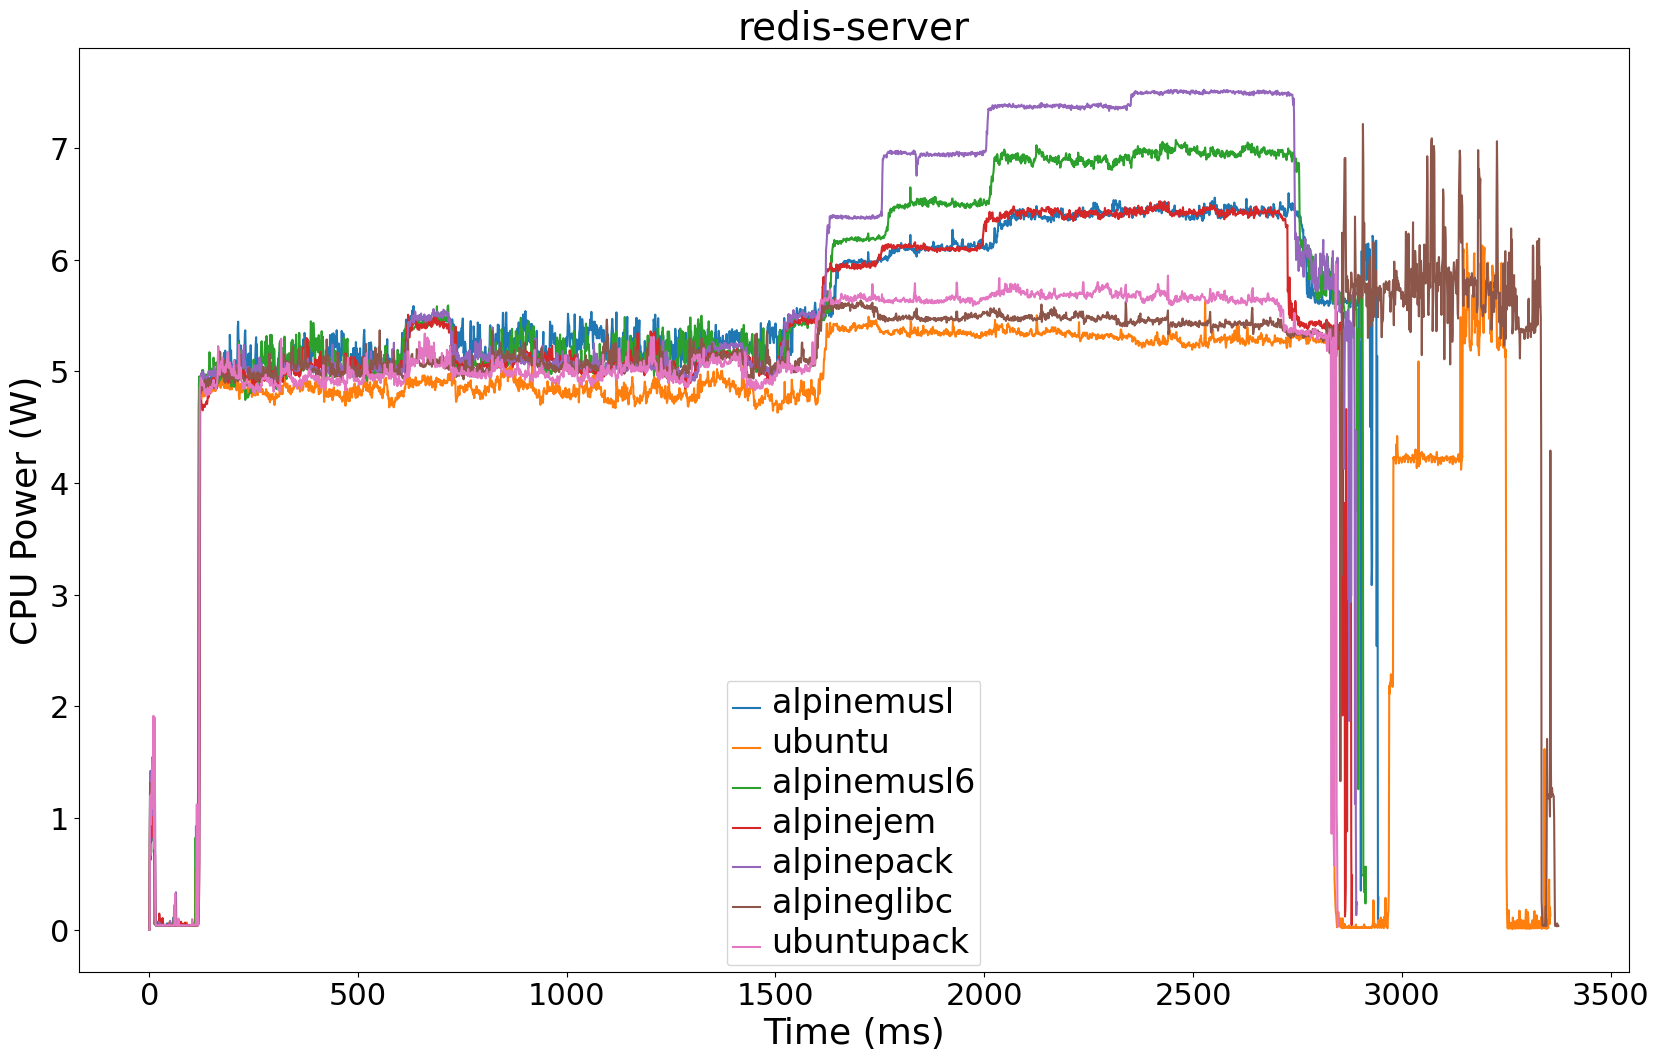

In [11]:
dataframes, aggregate = energy_data(workload, images)

In [19]:
# Compare power usage in a point of time
time = 2500
ubuntu_power = dataframes["ubuntu"].norm_dfs["median"]["CPU_POWER (Watts)"].iloc[time]
alpine_power = dataframes["alpinejem"].norm_dfs["median"]["CPU_POWER (Watts)"].iloc[time]

alpine_power
ubuntu_power

5.231221517074072

In [12]:
aggregate.groupby("Image").describe(include="all")

Time (s)                                                        
               count        mean        std      min        25%       50%   
Image                                                                       
alpineglibc     30.0  284.163933  10.206018  278.949  281.24900  282.3990  \
alpinejem       30.0  284.151233   1.848690  281.251  282.94875  283.7515   
alpinemusl      30.0  288.382467   2.265949  283.548  287.12750  288.1535   
alpinemusl6     30.0  286.937500   2.342816  280.849  285.67475  286.8470   
alpinepack      30.0  286.535233   1.347058  284.152  285.57500  286.4015   
ubuntu          30.0  295.271433   7.954821  288.177  293.12575  294.1805   
ubuntupack      30.0  281.629333   1.706169  278.344  280.37100  281.9985   

                                Energy (J)                           
                   75%      max      count         mean        std   
Image                                                                
alpineglibc  283.47725  337.589       30.0  1435.277323  24.093821  \
alpinejem    285.10075  288.155       30.0  1521.591435  16.772305   
alpinemusl   289.49925  294.459       30.0  1578.997693  27.443951   
alpinemusl6  288.62850  291.451       30.0  1612.097829  22.811095   
alpinepack   287.40500  289.353       30.0  1651.107956  15.555502   
ubuntu       295.57650  335.701       30.0  1401.535518  32.811963   
ubuntupack   282.67675  284.848       30.0  1441.416253  26.118245   

                                                                              
                     min          25%          50%          75%          max  
Image                                                                         
alpineglibc  1395.170670  1422.231220  1436.256866  1446.272015  1527.899826  
alpinejem    1478.248322  1513.799770  1522.085472  1531.187565  1559.119522  
alpinemusl   1527.422195  1564.220512  1578.587234  1590.771160  1665.700562  
alpinemusl6  1575.141922  1593.185928  1611.539146  1626.672798  1666.989563  
alpinepack   1622.637558  1644.226643  1650.471428  1657.752132  1702.232361  
ubuntu       1340.059143  1382.077553  1399.722046  1419.141323  1481.168533  
ubuntupack   1390.448059  1427.231281  1438.617828  1456.505371  1494.293991

In [21]:
# Mean energy consumption
energy_means = aggregate.groupby("Image").mean().reset_index()[["Image", "Energy (J)"]]
energy_means

,Image,Energy (J)
0,alpineglibc,1435.277323
1,alpinejem,1521.591435
2,alpinemusl,1541.845516
3,alpinepack,1651.107956
4,ubuntu,1401.535518
5,ubuntupack,1441.416253


In [22]:
percentual_difference_matrix(energy_means, "Image", "Energy (J)")

,alpineglibc,alpinejem,alpinemusl,alpinepack,ubuntu,ubuntupack
alpineglibc,0.000000,-5.672621,-6.911730,-13.071867,2.407488,-0.425896
alpinejem,6.013758,0.000000,-1.313626,-7.844219,8.566027,5.562250
alpinemusl,7.424920,1.331112,0.000000,-6.617522,10.011162,6.967402
alpinepack,15.037556,8.511912,7.086471,0.000000,17.807072,14.547616
ubuntu,-2.350891,-7.890155,-9.100133,-15.115452,0.000000,-2.766774
ubuntupack,0.427717,-5.269166,-6.513575,-12.700060,2.845503,0.000000


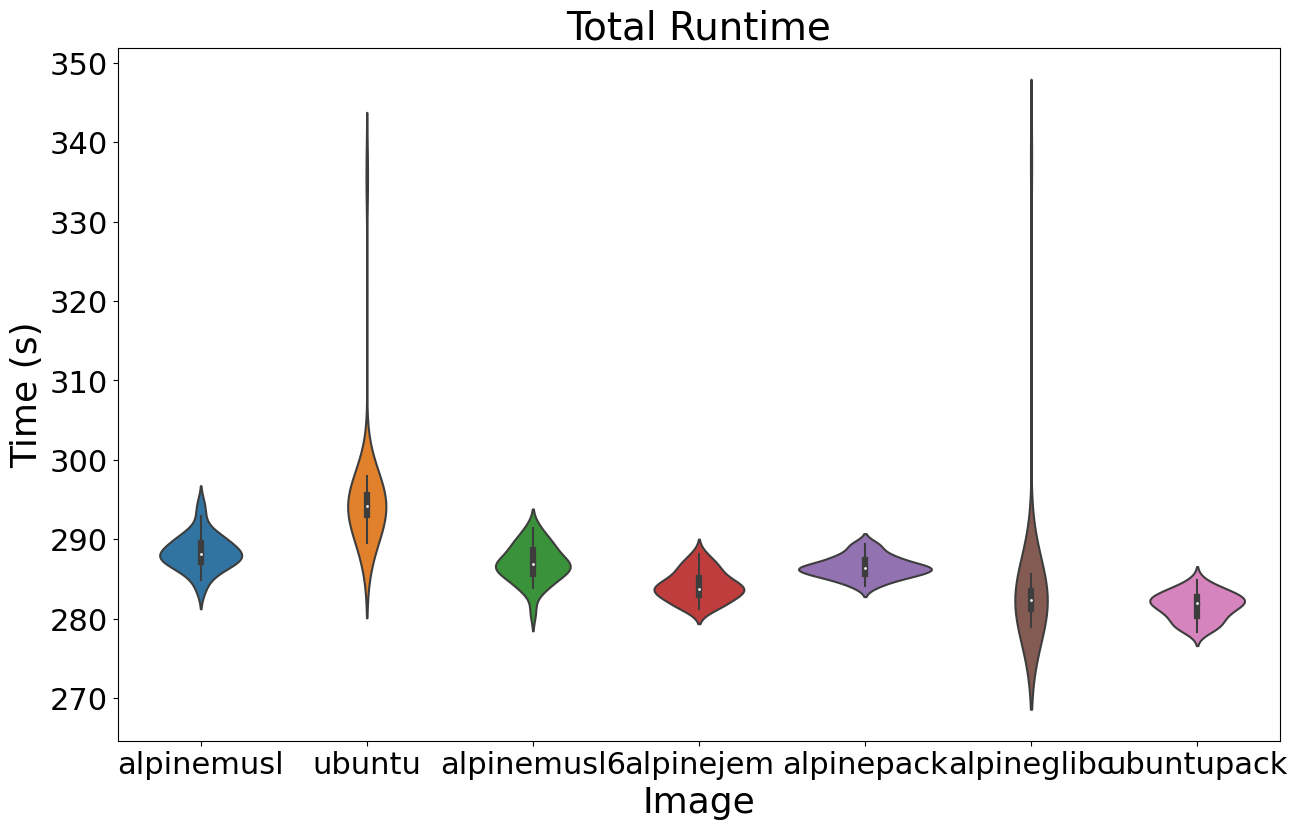

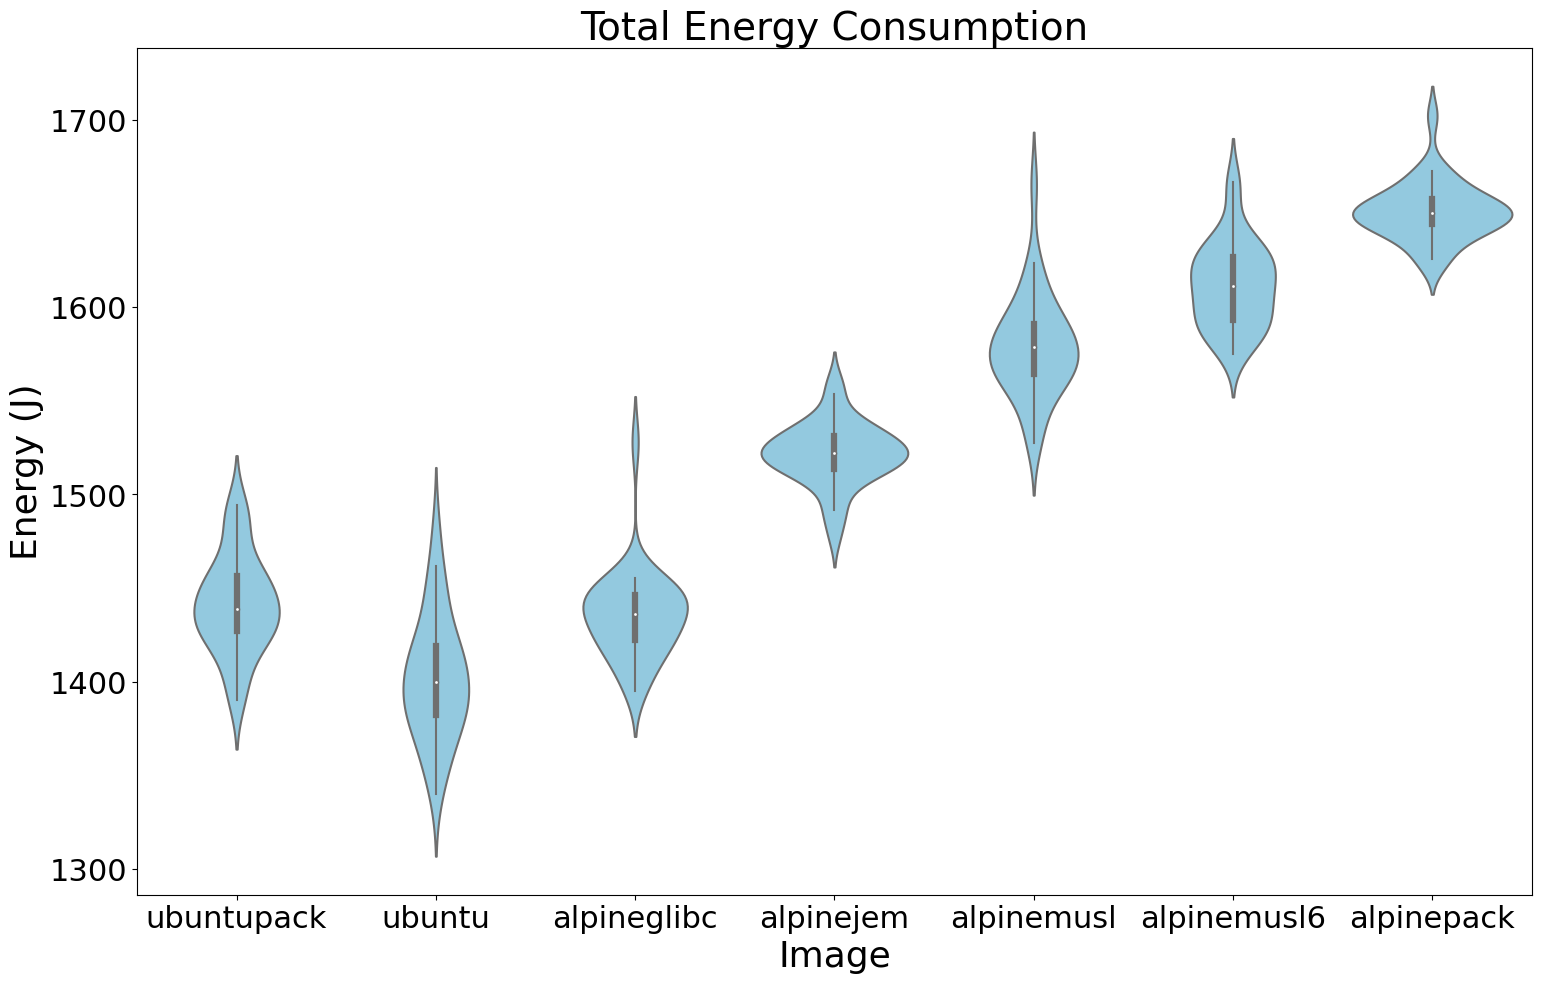

In [17]:
fig, ax = plt.subplots(figsize=[18,11])
sns.violinplot(x="Image", y="Time (s)", data=aggregate)

ax.set_xlabel("Image", size=26)
ax.set_ylabel("Time (s)", size=26)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)   
plt.title("Total Runtime", size=28)
plt.show()

fig, ax = plt.subplots(figsize=[18,11])
order = ["ubuntupack", "ubuntu", "alpineglibc", "alpinejem", "alpinemusl", "alpinemusl6", "alpinepack"]
sns.violinplot(x="Image", y="Energy (J)", data=aggregate, order=order, color="skyblue")

ax.set_xlabel("Image", size=26)
ax.set_ylabel("Energy (J)", size=26)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Total Energy Consumption", size=28)

plt.show()

## Step 2: Tracing with uftrace <a id='tracing'></a> 
The next step is to run the workload with *uftrace*. For this, it is recommended again to use docker. One of the Dockerfiles from the previous step can be reused by adding the installation steps of *uftrace* before the rest of the setup.

It is important to use the *ts* tool from [moreutils](https://joeyh.name/code/moreutils/) to have timestamps in the log that are consistent with the logs from docker-energy.

An example with redis is included in `docker/redis-traced`. You can use this as a template for your own tracing experiment. To run, use:

```
docker compose -f docker/redis-traced/docker-compose.yml build
docker compose -f docker/redis-traced/docker-compose.yml up --abort-on-container-exit 2>&1 | ts %.s > ./data/redis-server/logs/traced.txt
```

This will create the tracing data folder and the log file to use later during analysis

## Step 3: Trace analysis <a id='trace-analysis'></a> 
You can use the newly generated uftrace data folder to analyze some of the aspects of the workload execution. For example, you can use *uftrace report* to obtain general stats about function usage.

To keep using this notebook, you will need to use the *uftrace* fork available [here](https://github.com/enriquebarba97/uftrace), which increases the resolution of the time units displayed on some of the commands.

The replay of the calls realized during the workload can be seen with *uftrace replay*. This notebook uses the output of this command with the modified timestamp format. To obtain the necessary file, run:

```
uftrace replay -d {dir} -f rawElapsed,rawDuration > tracing.log
```

### Finding checkpoints
To find checkpoints in the logs, and the equivalent lines in the tracing, the following files are necessary:

- The log file from one of the runs of the energy experiment
- The energy data CSV from the equivalent run
- The log file of the tracing run

The reference run from the energy experiment can be chosen manually

In [24]:
# Utility code for cleaning and loading trace data
toRemove = [
  "[0-9]{10}\.[0-9]{6}",
  "(\d{1,4})(-|\/| )(\d{1,2})(-|\/| )(\d{1,4})( |T)?",
  "(\d{1,2}):(\d{1,2}):(\d{1,2})((\.|\+|,)(\d{1,7})Z?)?( (PM|AM|pm|am))?( [A-Z]{3})?",
  ".{3},?( .{3})? +(\d{1,2})( +.{3})?( |,)+(\d{1,4})",
  "\((\d+)\/(\d+)\)",
  "(\@|\$\$)[0-9a-z]+(\:|{|,|]| )",
  "[0-9a-fA-F]{8}\-[0-9a-fA-F]{4}\-[0-9a-fA-F]{4}\-[0-9a-fA-F]{4}\-[0-9a-fA-F]{12}",
  "(\d{5,})",
  "([0-9a-f]{10,})",
  "\d+:\d+ min",
  "(-->) +(\d+)%",
  "([\d\.]+)m?s",
  "([\d\.]+)m?illiseconds",
  "([0-9\.]+)M=0s",
  "([0-9\,\.]+) ?(kb|mb|m|b)(\/s)?",
  "([0-9\.]+) (seconds|secs|s|sec)",
  "(▉|█|▋)+",
  "={3,}>? *",
  "(\[|\|)\d+\/\d+(\]||\|)",
  "(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})",
  "\d{1,2} ?%",
]

class Trace:

    def __init__(self, path, tool="uftrace"):
        self.path = path
        filename = os.path.basename(self.path)
        dir = os.path.dirname(self.path)
        self.filename = os.path.splitext(filename)[0]
        self.csv = os.path.join(dir, self.filename + ".csv")
        self.line_count = self.count_lines()
        self.tool = tool
    
    def _count_generator(self, reader):
        b = reader(1024 * 1024)
        while b:
            yield b
            b = reader(1024 * 1024)

    def count_lines(self):
        with open(self.path, "rb") as file:
            c_generator = self._count_generator(file.raw.read)
            # count each \n
            count = sum(buffer.count(b'\n') for buffer in c_generator)
            return count + 1
        
    def compute_summary(self, exclude=[]):
        filtered = self.trace_data[~self.trace_data["Function"].isin(exclude)]

        count = filtered.groupby("Function")["Duration"].agg(['sum','count']).rename(columns={"sum":"Runtime (ns)", "count":"Calls"}).reset_index()
        count["Runtime %"] = count["Runtime (ns)"]/count["Runtime (ns)"].sum()*100
        count["Call %"] = count["Calls"]/count["Calls"].sum()*100
        return count.sort_values("Runtime %", ascending=False)
    
    def compute_bins(self, max_index, checkpoints_trace=None, indices=None, exclude=[]):
        filtered = self.trace_data[~self.trace_data["Function"].isin(exclude)]

        left = self.trace_data["Time"].iloc[0]
        rel_left = 0
        max_time = self.trace_data["Time"].iloc[-1]

        runtimes = pd.DataFrame(columns=["Function", "Time", "Duration"])

        checkpoints = []
        if checkpoints_trace is None:
            for i in range(1,10):
                checkpoints.append((i/10, i*max_time/10))
        else:
            for i in range(len(checkpoints_trace)):
                checkpoints.append((checkpoints_trace[i][0], checkpoints_trace[i][1]*1e3))
        
        if indices is None:
            indices = [int(i*max_index/10) for i in range(1,10)]

        for i in range(len(checkpoints) + 1):
            if i == len(checkpoints):
                right = self.trace_data["Time"].iloc[-1]
                rel_right = max_index
            else:
                right = checkpoints[i][1]
                rel_right = indices[i]

            slice = filtered[(filtered["Time"]>=left) & (filtered["Time"]<right)]
            durations = slice.groupby("Function")["Duration"].sum().reset_index()
            durations["Time"] = rel_left
            durations = durations.sort_values("Duration", ascending=False).head(5)
            runtimes = pd.concat([runtimes, durations], ignore_index=True)

            left = right
            rel_left = rel_right
        
        return runtimes, [0] + indices + [max_index]

    def process_ltrace(self, file, out):
        """Parse tracing data from ltrace util (deprecated)"""

        for num, line in enumerate(file):

            if num % 100000 == 0:
                print(num)

            strs = line.split()

            if len(strs) < 3:
                continue

            try:
                current_ts = float(strs[1])
            except ValueError:
                continue
                
            fun_info = strs[2]

            index = fun_info.find("(")
            if index == -1:
                continue
            fun = fun_info[:index]

            start_duration = line.rfind("<")
            end_duration = line.rfind(">")
            if start_duration == -1 or end_duration == -1:
                continue
            duration = line[start_duration + 1:end_duration]
                
            try:
                duration = float(duration)
            except ValueError:
                continue
                
            out.write(f"{current_ts},{fun},{duration}\n")
    
    def process_uftrace(self, file, out):
        """Parse tracing data from uftrace util"""

        ongoing = ""
        ongoing_time = 0
        for num, line in enumerate(file):
            if num == 0:
                continue

            if num % 100000 == 0:
                print(num)

            # Remove character | from line
            line = line.replace("|", "")

            strs = line.split()

            if len(strs) < 3:
                print(strs)
                continue
            
            if len(strs) == 4 and strs[3] == "{":
                ongoing = strs[2].replace("(", "").replace(")", "").replace(";", "")
                ongoing_time = int(strs[1])
                continue

            try:
                duration = int(strs[0])
                elapsed = int(strs[1])
                fun = strs[2].replace("(", "").replace(")", "").replace(";", "")
                if fun == "}":
                    fun = ongoing
                    elapsed = ongoing_time
                    ongoing = ""
                    ongoing_time = 0
                
            except ValueError:
                continue

            out.write(f"{elapsed},{fun},{duration}\n")

    def to_csv(self):
        """Convert trace data to csv for easier loading in the future"""

        with open(self.path, "r") as file, open(self.csv, "w") as out:

            out.write("Time,Function,Duration\n")

            if self.tool == "uftrace":
                self.process_uftrace(file, out)
            else:
                self.process_ltrace(file, out)
            

    def load_data(self):
        """Load data from CSV if exist, otherwise convert and load"""

        # Check if csv exists
        if not os.path.exists(self.csv):
            self.to_csv()
        
        self.trace_data = pd.read_csv(self.csv, dtype={"Time": "int64", "Function": "string", "Duration": "uint16"})
        #self.trace_data["Time"] = pd.to_datetime(self.trace_data["Time"], unit="s")
            

def lines_to_dataframe(lines):
    """Load lines from the log into a dataframe"""

    dataframe = {"Line": [], "Progress": []}

    for i, line in enumerate(lines):
        line = line.strip()
        dataframe["Line"].append(line)
        dataframe["Progress"].append(i/len(lines))
    
    return pd.DataFrame(dataframe)

def get_relevant_lines(df, max_count=1, lower=0.01, upper=0.99):
    """Get relevant lines from the log"""

    count = df["Line"].value_counts()
    unique_lines = df[~df["Line"].isin(count[count > max_count].index)].reset_index(names=["Line Number"])
    return unique_lines[(unique_lines["Progress"]>lower) & (unique_lines["Progress"]<upper)]

def remove_nums_line(line):
    return ''.join([i for i in line if not i.isdigit()])

def clean_line(line):
    """Clean numbers and other irrelevant data from the line"""

    for pattern in toRemove:
        line = re.sub(pattern, "", line)
    return line

def find_timestamp(lines, start):
    """Find timestamp in the log closer to the start index
        Returns the timestamp in microseconds"""

    for j in range(start, len(lines)):
        line = lines[j]
        try:
            timestamp = line.split()[0]
            if re.match(r"[0-9]{10}\.[0-9]{6}", timestamp):
                timestamp = int(float(timestamp)*1e6)
                return timestamp
            elif re.match(r"[0-9]{10}", timestamp):
                timestamp = int(timestamp)*1e6
                return timestamp
        except IndexError:
            continue
    
    return None

In [57]:
reference_log_path = f"data/{workload}/logs/reference.txt"
tracing_log_path = f"data/{workload}/logs/traced.txt"
reference_data = pd.read_csv(f"data/{workload}/energy/reference.tsv", usecols=["Delta", "Time", "CORE0_ENERGY (J)", "USED_MEMORY", "CPU_USAGE_0"])

In [58]:
with open(reference_log_path, "r") as file:
    lines_ref = file.readlines()
    clean_lines = [clean_line(line) for line in lines_ref]

    df_lines = lines_to_dataframe(clean_lines)

    relevant_lines_ref = get_relevant_lines(df_lines, max_count=1, lower=0.07, upper=0.95)

relevant_lines_ref

,Line Number,Line,Progress
97,245,PING_MBULK,0.070463
98,279,redis-server-client-1 | 0.0 <= illiseconds (c...,0.080242
99,300,redis-server-client-1 | throughput summary:...,0.086281
100,303,redis-server-client-1 | 0.272 0.0...,0.087144
101,305,SET: rps=.0 (overall: .0) avg_msec=0.275 (over...,0.087719
...,...,...,...
1097,3247,LRANGE_600 (first 600 elements): rps=.4 (overa...,0.933851
1098,3249,LRANGE_600 (first 600 elements),0.934426
1099,3285,redis-server-client-1 | 0.0 <= illiseconds (c...,0.944780
1100,3288,redis-server-client-1 | 1.8 <= illiseconds (c...,0.945643


In [59]:
with open(tracing_log_path, "r") as file:

    lines_traced = file.readlines()
    clean_lines = [clean_line(line) for line in lines_traced]

    df_lines = lines_to_dataframe(clean_lines)

    min_time = find_timestamp(lines_traced, 0)

    relevant_lines_traced = get_relevant_lines(df_lines, max_count=1, lower=0.07, upper=0.95)

relevant_lines_traced

,Line Number,Line,Progress
44,138,client-1 | 0.1 <= illiseconds (cumulative...,0.083133
45,139,client-1 | 0.5 <= illiseconds (cumulative...,0.083735
46,140,client-1 | 1.3 <= illiseconds (cumulative...,0.084337
47,141,client-1 | 3.6 <= illiseconds (cumulative...,0.084940
48,142,client-1 | 15.6 <= illiseconds (cumulativ...,0.085542
...,...,...,...
447,1553,client-1 | 46.1 <= illiseconds (cumulativ...,0.935542
448,1554,client-1 | 67.1 <= illiseconds (cumulativ...,0.936145
449,1555,client-1 | 81.1 <= illiseconds (cumulativ...,0.936747
450,1556,client-1 | 88.8 <= illiseconds (cumulativ...,0.937349


In [60]:
# Intersection of relevant lines
relevant_lines = relevant_lines_ref[relevant_lines_ref["Line"].isin(relevant_lines_traced["Line"])]
relevant_lines["Line Number Trace"] = [relevant_lines_traced[relevant_lines_traced["Line"] == line]["Line Number"].values[0] for line in relevant_lines["Line"]]
relevant_lines

/tmp/ipykernel_10619/2673121901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_lines["Line Number Trace"] = [relevant_lines_traced[relevant_lines_traced["Line"] == line]["Line Number"].values[0] for line in relevant_lines["Line"]]


,Line Number,Line,Progress,Line Number Trace
140,387,SET,0.111303,181
183,525,GET,0.150992,255
222,663,INCR,0.190682,324
269,809,LPUSH,0.232672,400
312,954,RPUSH,0.274374,474
354,1090,LPOP,0.313489,547
399,1231,RPOP,0.354041,618
439,1372,SADD,0.394593,683
484,1512,HSET,0.434858,750
530,1656,SPOP,0.476273,822


In [61]:
# %%
checkpoints_ref = []
checkpoints_trace = []

for i in relevant_lines.index:
    start_ref = relevant_lines["Line Number"][i]
    start_trace = relevant_lines["Line Number Trace"][i]
    
    timestamp = find_timestamp(lines_ref, start_ref)
    if timestamp is not None:
        checkpoints_ref.append((lines_ref[start_ref], timestamp/1000, relevant_lines["Progress"][i]))
    
    timestamp = find_timestamp(lines_traced, start_trace)
    if timestamp is not None:
        checkpoints_trace.append((lines_traced[start_trace], timestamp - min_time, relevant_lines["Progress"][i]))

In [62]:
# Find indices of reference checkpoints from the original power lineplot

size = reference_data.shape[0]

indices = []
indices_progress = []
for checkpoint in checkpoints_ref:
    index = reference_data[reference_data["Time"] > checkpoint[1]].index[0]
    if index not in indices:
        indices.append(index)
    
    indices_progress.append(int(checkpoint[2]*size))

if len(indices) < len(checkpoints_ref):
    indices = indices_progress


In [63]:
checkpoints_trace

[('====== SET ======\n', 14917532, 0.11130284728213978),
 ('====== GET ======\n', 15670497, 0.15099223468507333),
 ('====== INCR ======\n', 16681754, 0.1906816220880069),
 ('====== LPUSH ======\n', 17678836, 0.23267184354328443),
 ('====== RPUSH ======\n', 18685569, 0.274374460742019),
 ('====== LPOP ======\n', 19434955, 0.3134886396318666),
 ('====== RPOP ======\n', 20437511, 0.35404083980442913),
 ('====== SADD ======\n', 21189771, 0.39459303997699163),
 ('====== HSET ======\n', 21942563, 0.43485763589301124),
 ('====== SPOP ======\n', 22694641, 0.47627264883520276),
 ('====== ZADD ======\n', 23697645, 0.5197008915731953),
 ('====== ZPOPMIN ======\n', 24450297, 0.5611159045153868),
 ('====== LPUSH (needed to benchmark LRANGE) ======\n',
  25202313,
  0.6013805004314063),
 ('====== LRANGE_100 (first 100 elements) ======\n',
  27959859,
  0.6482599942479149),
 ('====== LRANGE_300 (first 300 elements) ======\n',
  33979846,
  0.725050330744895),
 ('====== LRANGE_500 (first 500 elements)

In [64]:
trace = Trace(os.path.abspath(f"data/{workload}/tracing/tracing.log"))
trace.load_data()

In [33]:
summary = trace.compute_summary()
summary.head(10)

,Function,Runtime (ns),Calls,Runtime %,Call %
42,memcpy,6594371865,115270590,39.562145,92.637077
110,write,6100079082,500006,36.596694,0.401829
74,read,2204989695,501557,13.228572,0.403076
18,epoll_wait,701065124,99494,4.205956,0.079958
93,strchr,238221535,2340922,1.429182,1.881279
92,strcasecmp,221697527,1776711,1.330048,1.427852
33,gettimeofday,152283682,1201218,0.913608,0.965357
41,memcmp,150901874,1307754,0.905318,1.050975
13,clock_gettime,117885050,898262,0.707237,0.721887
37,localtime_r,45398704,99495,0.272364,0.079959


In [65]:
max_index = reference_data.shape[0]
runtimes, indices = trace.compute_bins(max_index, checkpoints_trace, indices)

In [66]:
# Filter out some of the less relevant functions, based on output from uftrace report
runtimes = runtimes[~runtimes["Function"].isin(["close","strlen","pthread_mutex_trylock","pthread_mutex_unlock"])]

Text(0.5, 1.0, 'redis-server')

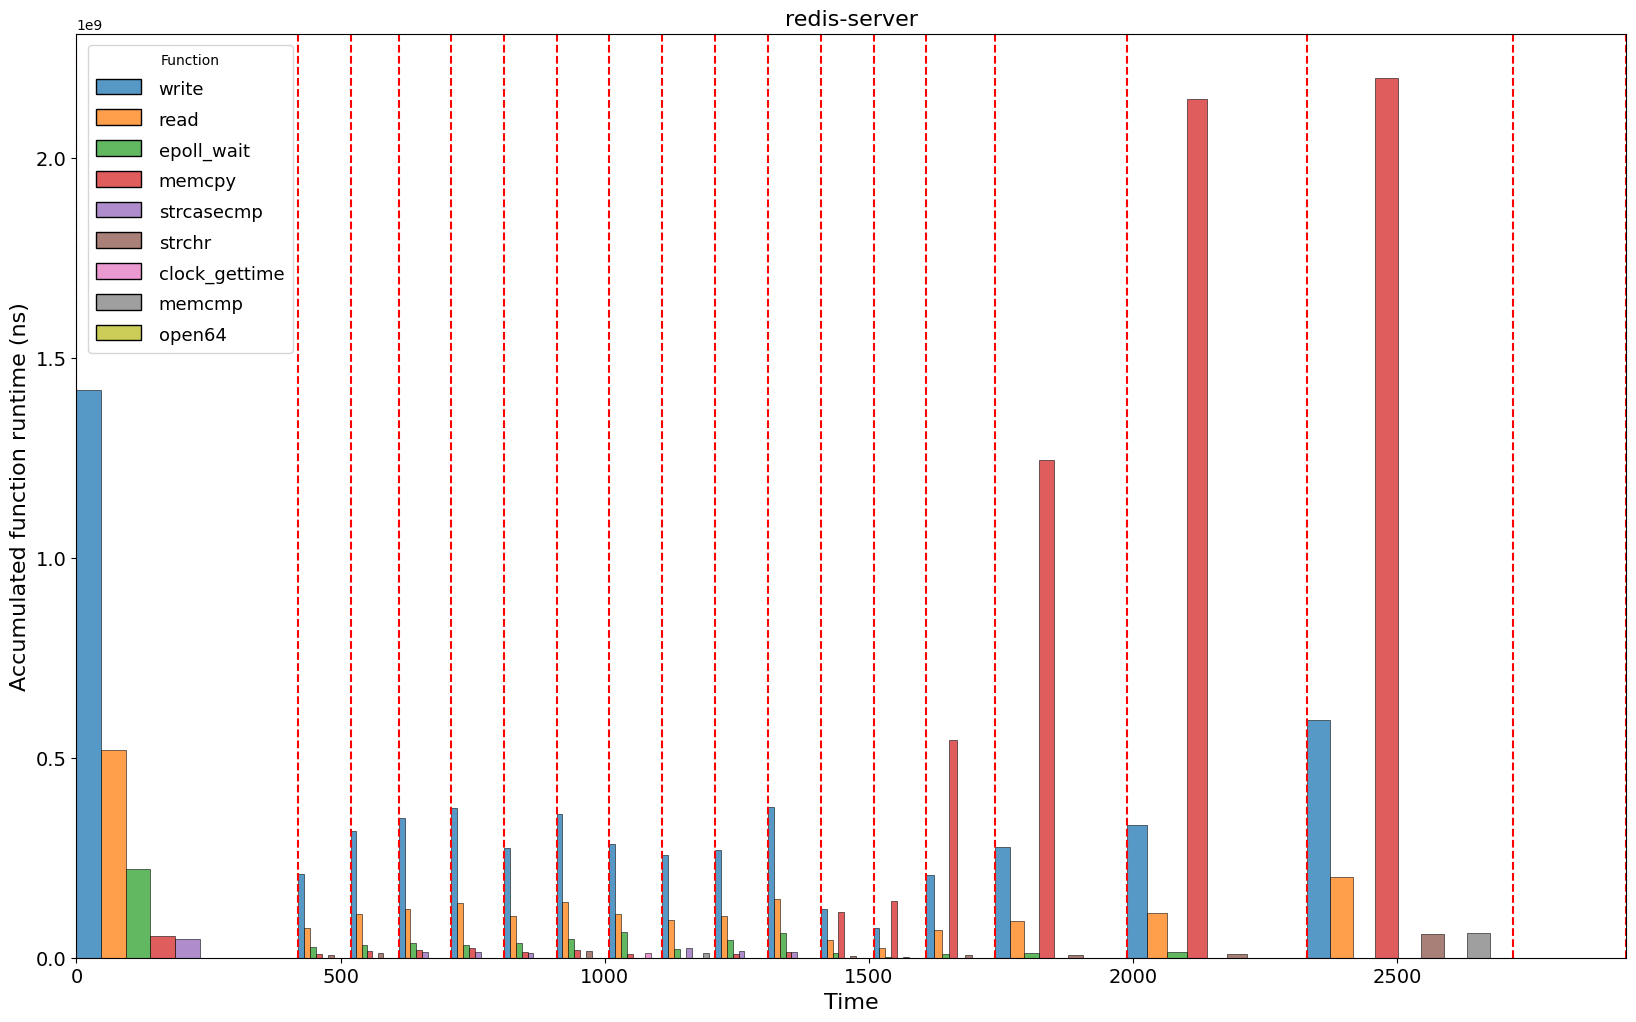

In [65]:
fig, ax = plt.subplots(figsize=[20,12])
ax.set_xlim(0, max_index)

sns.histplot(data=runtimes, x="Time", hue="Function", weights="Duration", multiple="dodge", bins=indices)

for index in indices:
    ax.axvline(x=index, color="red", linestyle="--")

ax.set_xlabel("Time (ms)", size=16)
ax.set_ylabel("Accumulated function runtime (ns)", size=16)

# Set axes numbers size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Change legend font size
plt.setp(ax.get_legend().get_texts(), fontsize='13')

plt.title("redis-server", size=16)

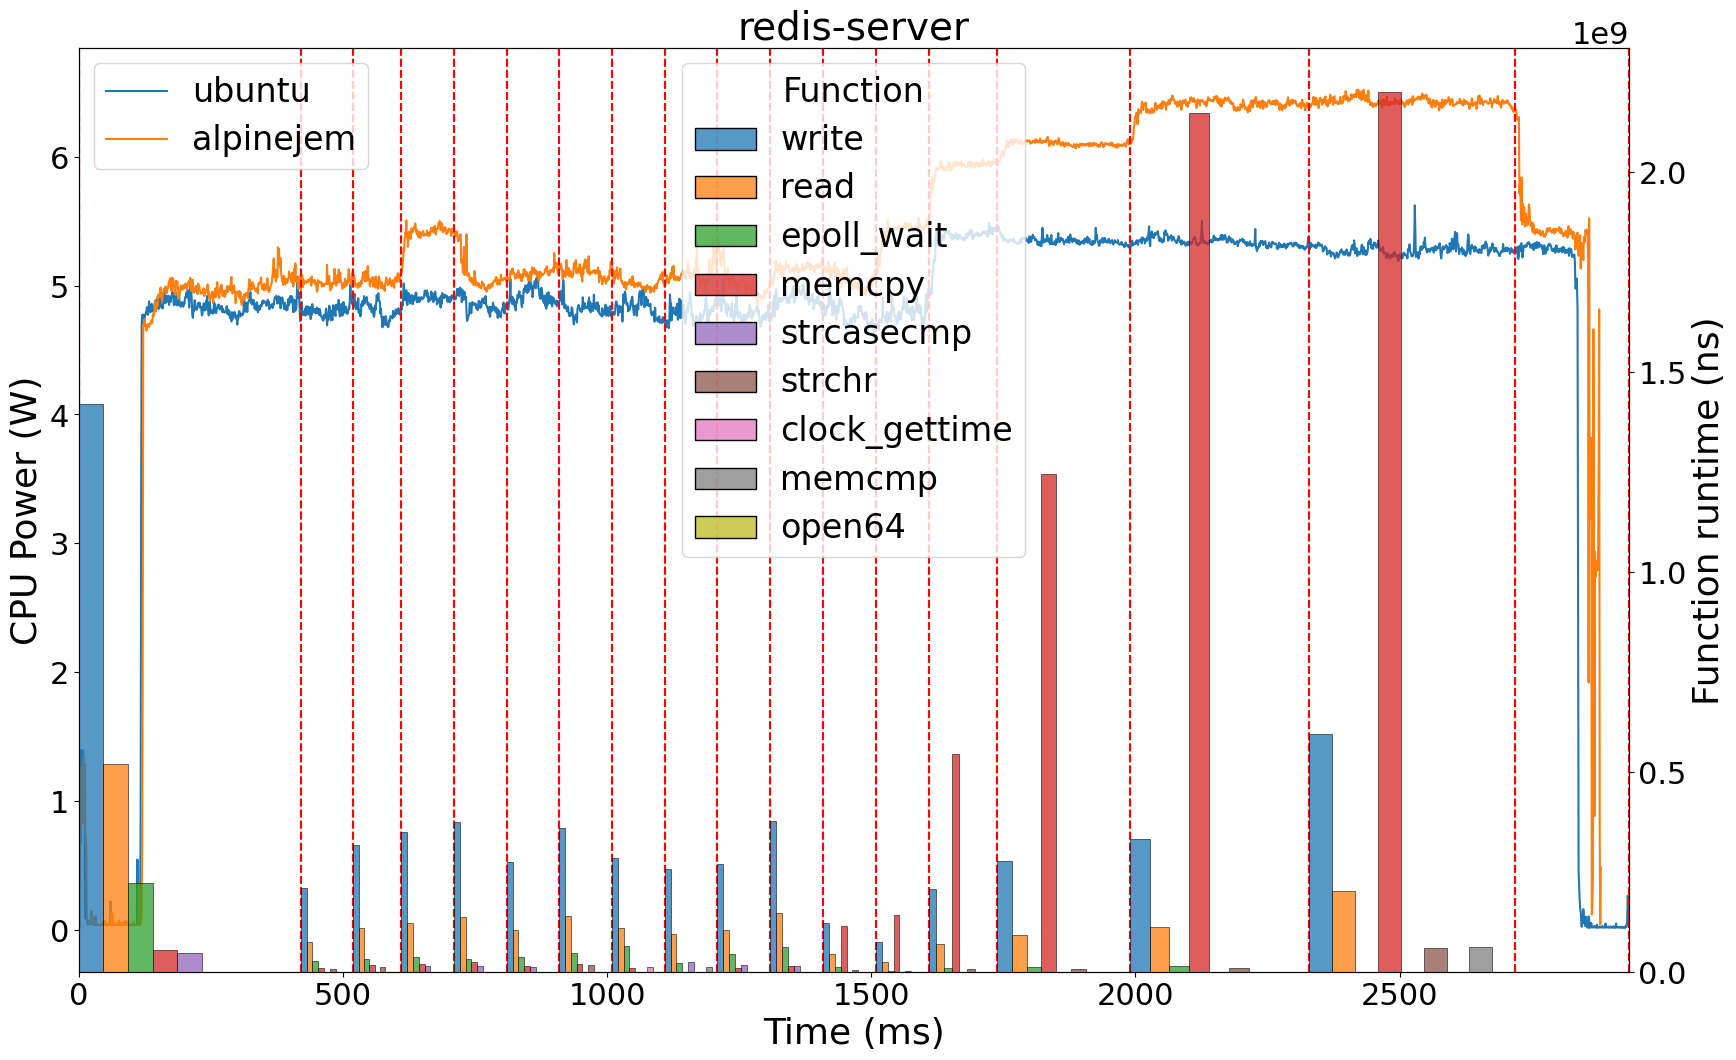

In [67]:
toplot = ["ubuntu", "alpinejem"]
_,_ =energy_data(workload, images, toplot=toplot, indices=indices, xlim=(0, max_index), hist_data=runtimes)


## Back to Step 2: Run and analyze a new benchmark

In [44]:
workload = "memcpy-benchmark-cached"

data_path = f"data/{workload}/energy"

images = next(os.walk(data_path))[1]

print(images)

['ubuntu@sha256b060fffe8e1561c9c3e6dea6db487b900100fc26830b9ea2ec966c151ab4c020', 'alpine@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'alpineglibc']


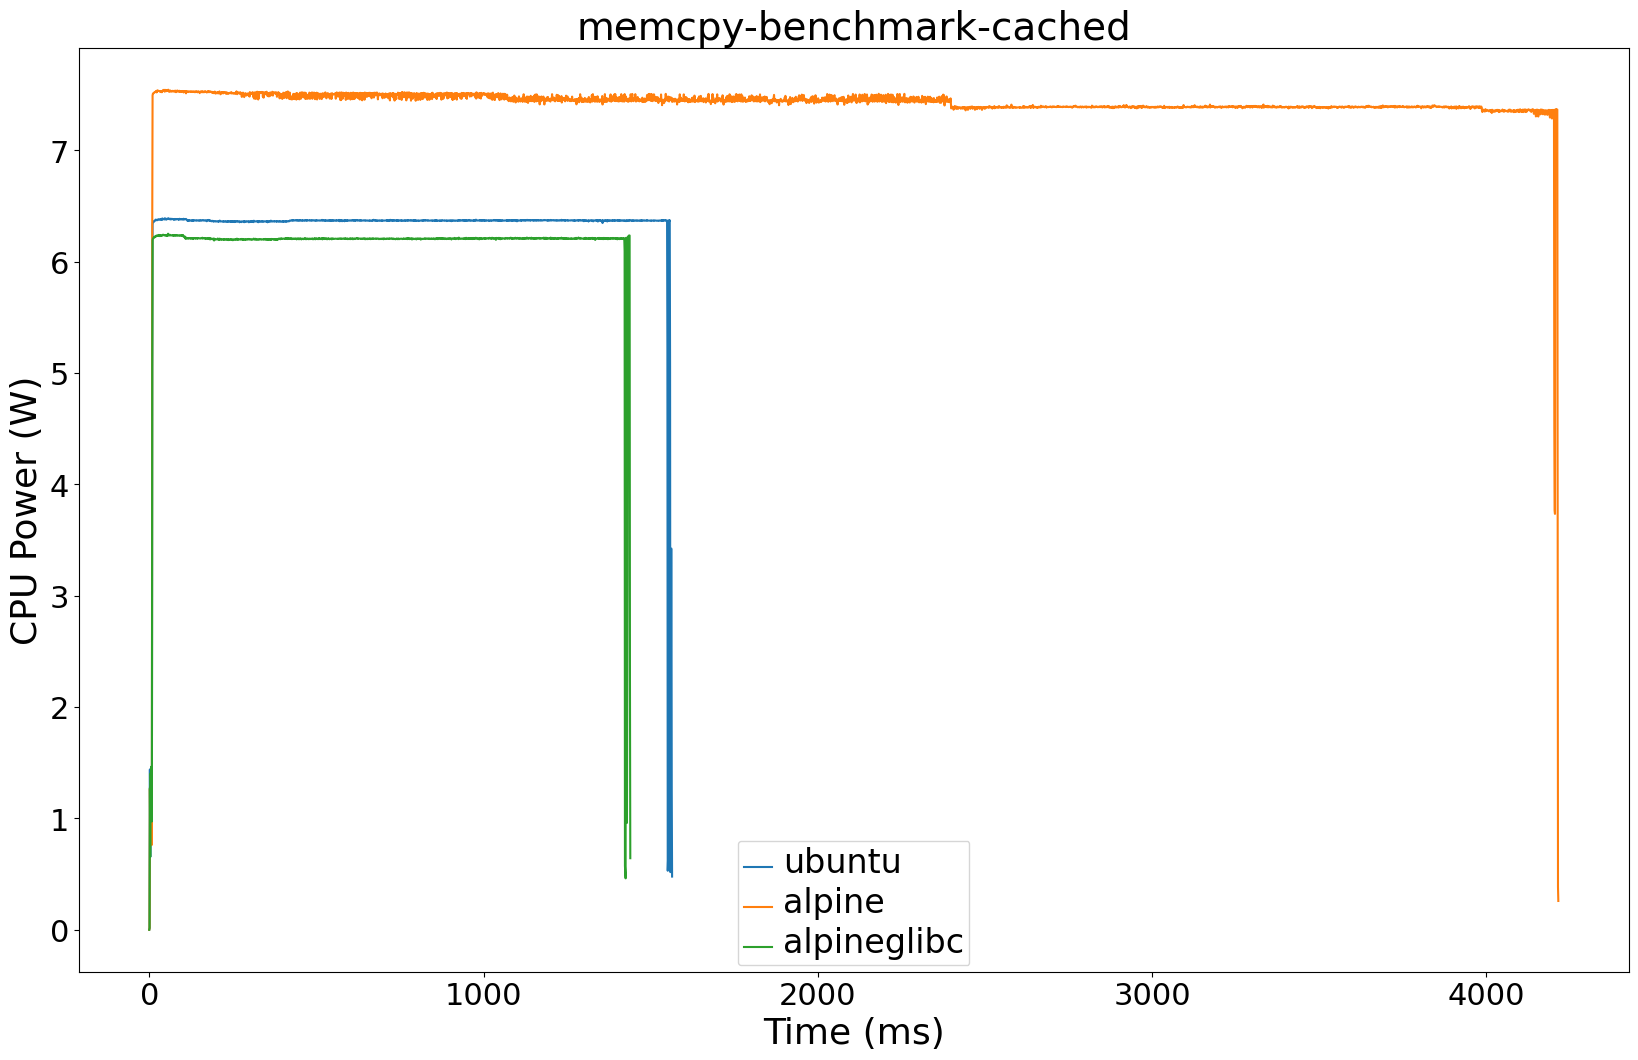

In [45]:
dataframes, aggregate = energy_data(workload, images, toplot=["ubuntu", "alpine","alpineglibc"])

In [23]:
aggregate.groupby("Image").describe(include="all")

Time (s)                                                            
               count       mean       std     min       25%     50%       75%   
Image                                                                           
alpine          23.0  91.336783  2.865227  85.565  90.31950  91.568  92.61450  \
alpineglibc     20.0  88.250700  3.418855  81.263  86.49025  88.566  90.09475   
ubuntu          22.0  89.832909  4.615608  80.740  86.57150  91.564  93.08750   

                    Energy (J)                                                  
                max      count        mean        std         min         25%   
Image                                                                           
alpine       98.870       23.0  352.638048  10.935049  332.436996  343.944023  \
alpineglibc  93.174       20.0  296.038557  14.827213  271.026321  282.891945   
ubuntu       96.552       22.0  312.177840  21.878657  271.867340  298.950077   

                                                 
                    50%         75%         max  
Image                                            
alpine       353.136810  357.771080  374.923828  
alpineglibc  295.288780  304.554710  330.569656  
ubuntu       309.158485  329.132355  360.746368

In [46]:
# Compare power usage in a point of time
time = 800
ubuntu_power = dataframes["ubuntu"].norm_dfs["median"]["CPU_POWER (Watts)"].iloc[time]
alpine_power = dataframes["alpine"].norm_dfs["median"]["CPU_POWER (Watts)"].iloc[time]

alpine_power - ubuntu_power

1.1486477322048607

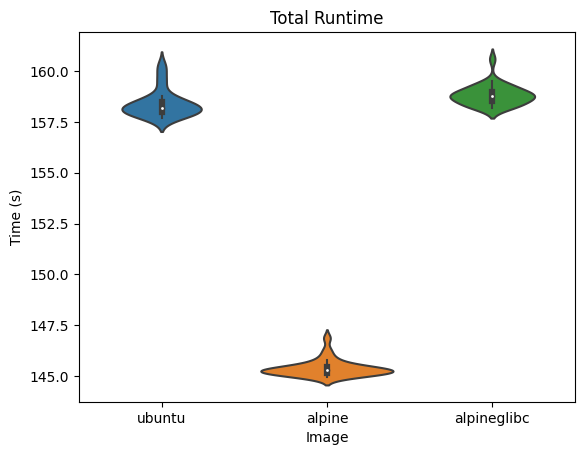

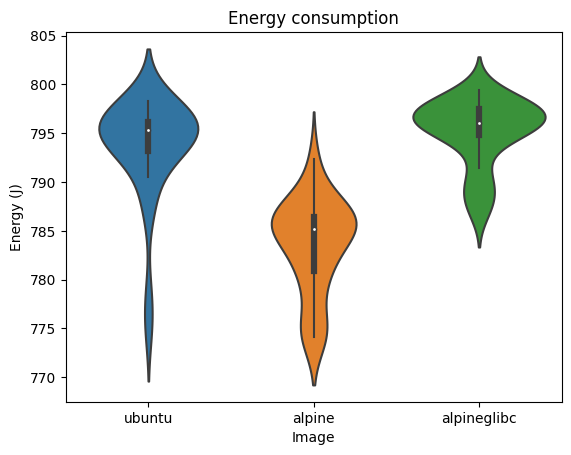

In [37]:
sns.violinplot(x="Image", y="Time (s)", data=aggregate)
plt.title("Total Runtime")
plt.show()

sns.violinplot(x="Image", y="Energy (J)", data=aggregate)
plt.title("Energy consumption")
plt.show()

## Another example with postgres

In [45]:
workload = "postgres-server"

data_path = f"data/{workload}/energy"

images = next(os.walk(data_path))[1]

print(images)

['ubuntu@sha256b060fffe8e1561c9c3e6dea6db487b900100fc26830b9ea2ec966c151ab4c020', 'alpine@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70']


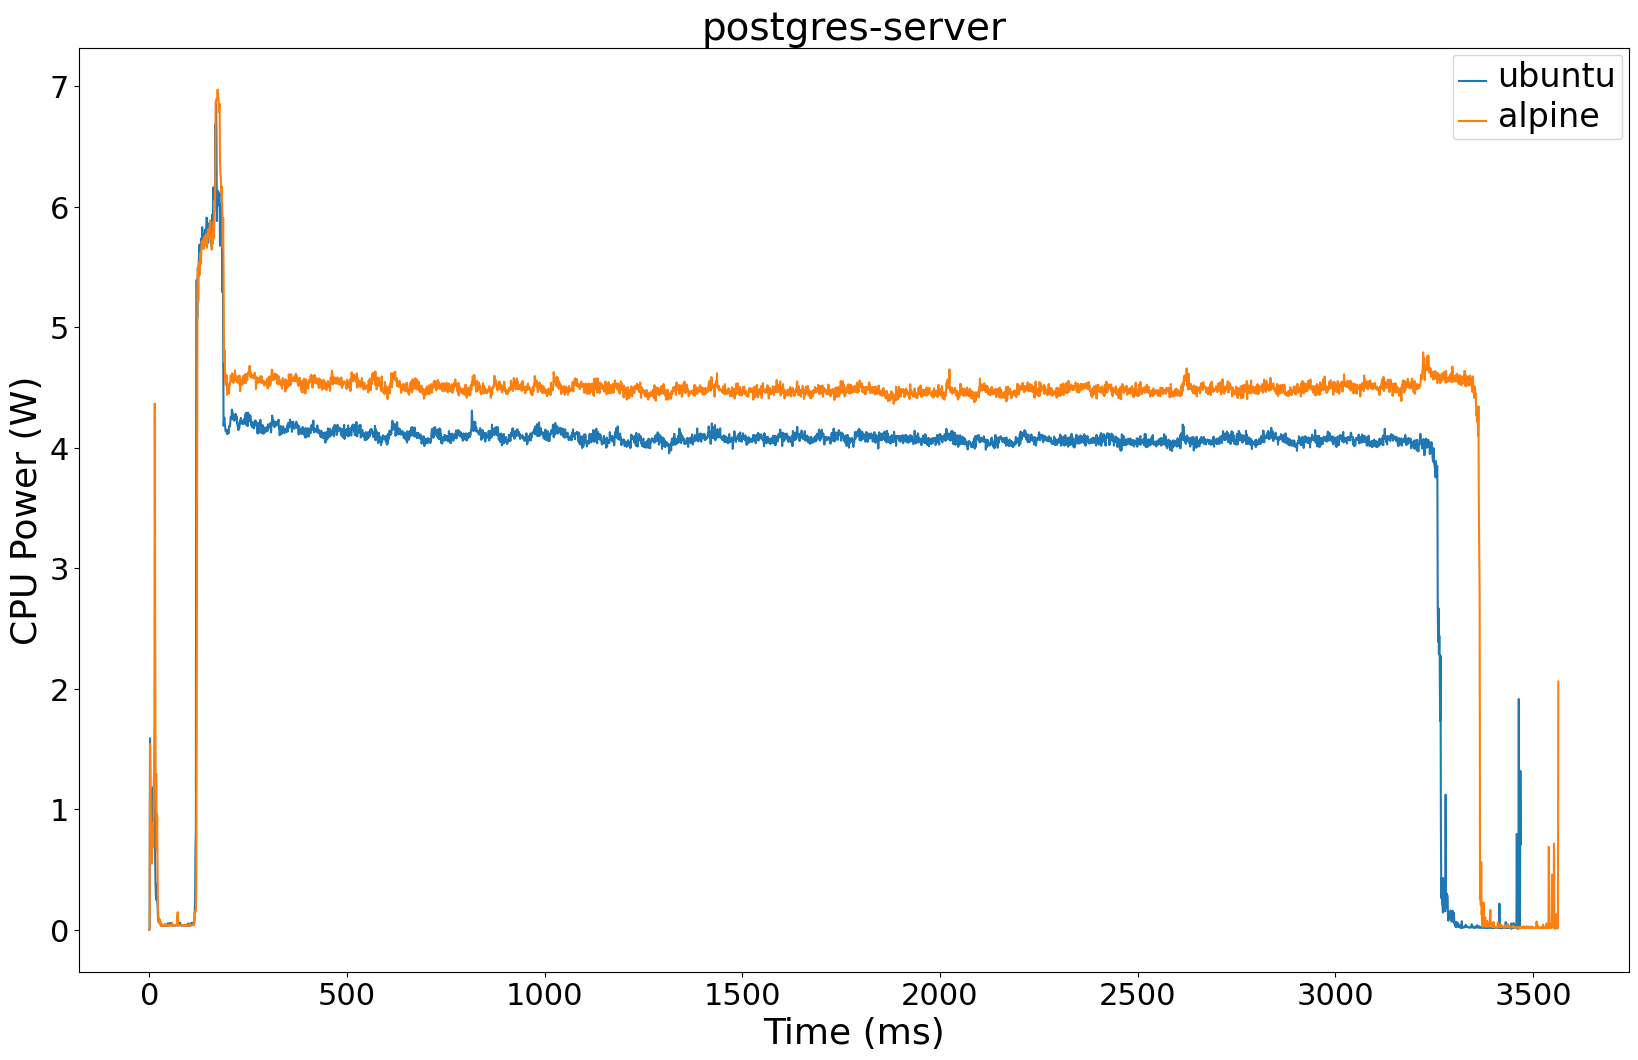

In [46]:
dataframes, aggregate = energy_data(workload, images)

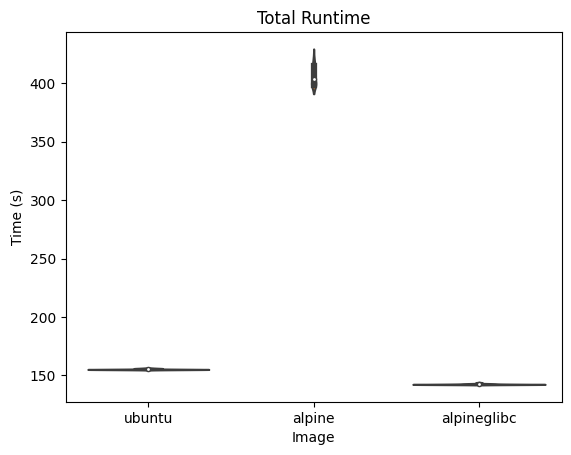

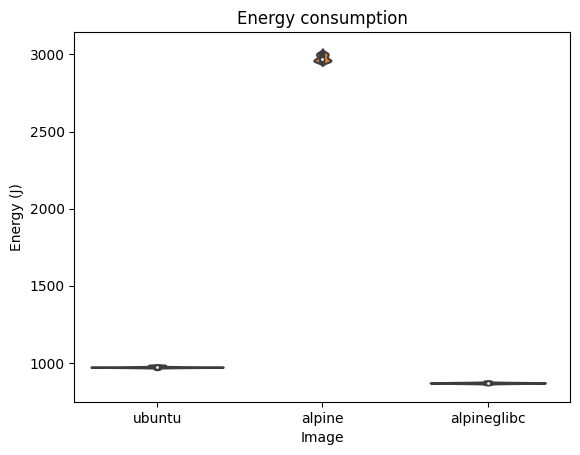

In [30]:
sns.violinplot(x="Image", y="Time (s)", data=aggregate)
plt.title("Total Runtime")
plt.show()

sns.violinplot(x="Image", y="Energy (J)", data=aggregate)
plt.title("Energy consumption")
plt.show()

In [47]:
reference_data = pd.read_csv(f"data/{workload}/energy/reference.tsv", usecols=["Delta", "Time", "CORE0_ENERGY (J)", "USED_MEMORY", "CPU_USAGE_0"])

Unlike Redis benchmark, *pgbench* is a uniform benchmark in terms of logic and functions tested. There are only two logical steps: generate data and benchmark, that are done through two separate commands.

This means that the time distorsion should be more uniform than in Redis. Additionaly, *pgbench* logs are not as detailed as the Redis logs. Instead of using checkpoints, we can divide the execution time in uniform intervals and normalize between those

In [48]:
trace = Trace(os.path.abspath(f"data/{workload}/tracing/tracing.log"))
trace.load_data()

In [12]:
summary = trace.compute_summary()
summary.head(10)

,Function,Runtime (ns),Calls,Runtime %,Call %
85,epoll_wait,11668930119,357797,19.794985,0.399812
57,SSL_write,9154192208,349604,15.529024,0.390657
53,SSL_read,8069133364,705128,13.688348,0.787930
157,send,6766784365,350356,11.479064,0.391498
148,recv,4675643546,1061822,7.931687,1.186510
132,memset,3655976982,39949235,6.201941,44.640396
143,pwrite,2019083997,180199,3.425142,0.201359
156,sem_wait,1860548575,56483,3.156205,0.063116
127,lseek,1804199688,493557,3.060615,0.551514
142,pread,1102366718,128930,1.870037,0.144070


In [49]:
max_index = reference_data.shape[0]
runtimes, indices = trace.compute_bins(max_index, exclude=["SSL_write","SSL_read"])

/home/enrique/Thesis/energy-hotspots/.venv/lib/python3.10/site-packages/seaborn/distributions.py:163: UserWarning: The label '__ctype_b_loc' of <matplotlib.patches.Patch object at 0x746f28a4b7f0> starts with '_'. It is thus excluded from the legend.
  ax_obj.legend(handles, labels, title=self.variables["hue"], **legend_kws)
/home/enrique/Thesis/energy-hotspots/.venv/lib/python3.10/site-packages/seaborn/distributions.py:163: UserWarning: The label '__sigsetjmp' of <matplotlib.patches.Patch object at 0x746f28a4b910> starts with '_'. It is thus excluded from the legend.
  ax_obj.legend(handles, labels, title=self.variables["hue"], **legend_kws)


Text(0.5, 1.0, 'postgres-server')

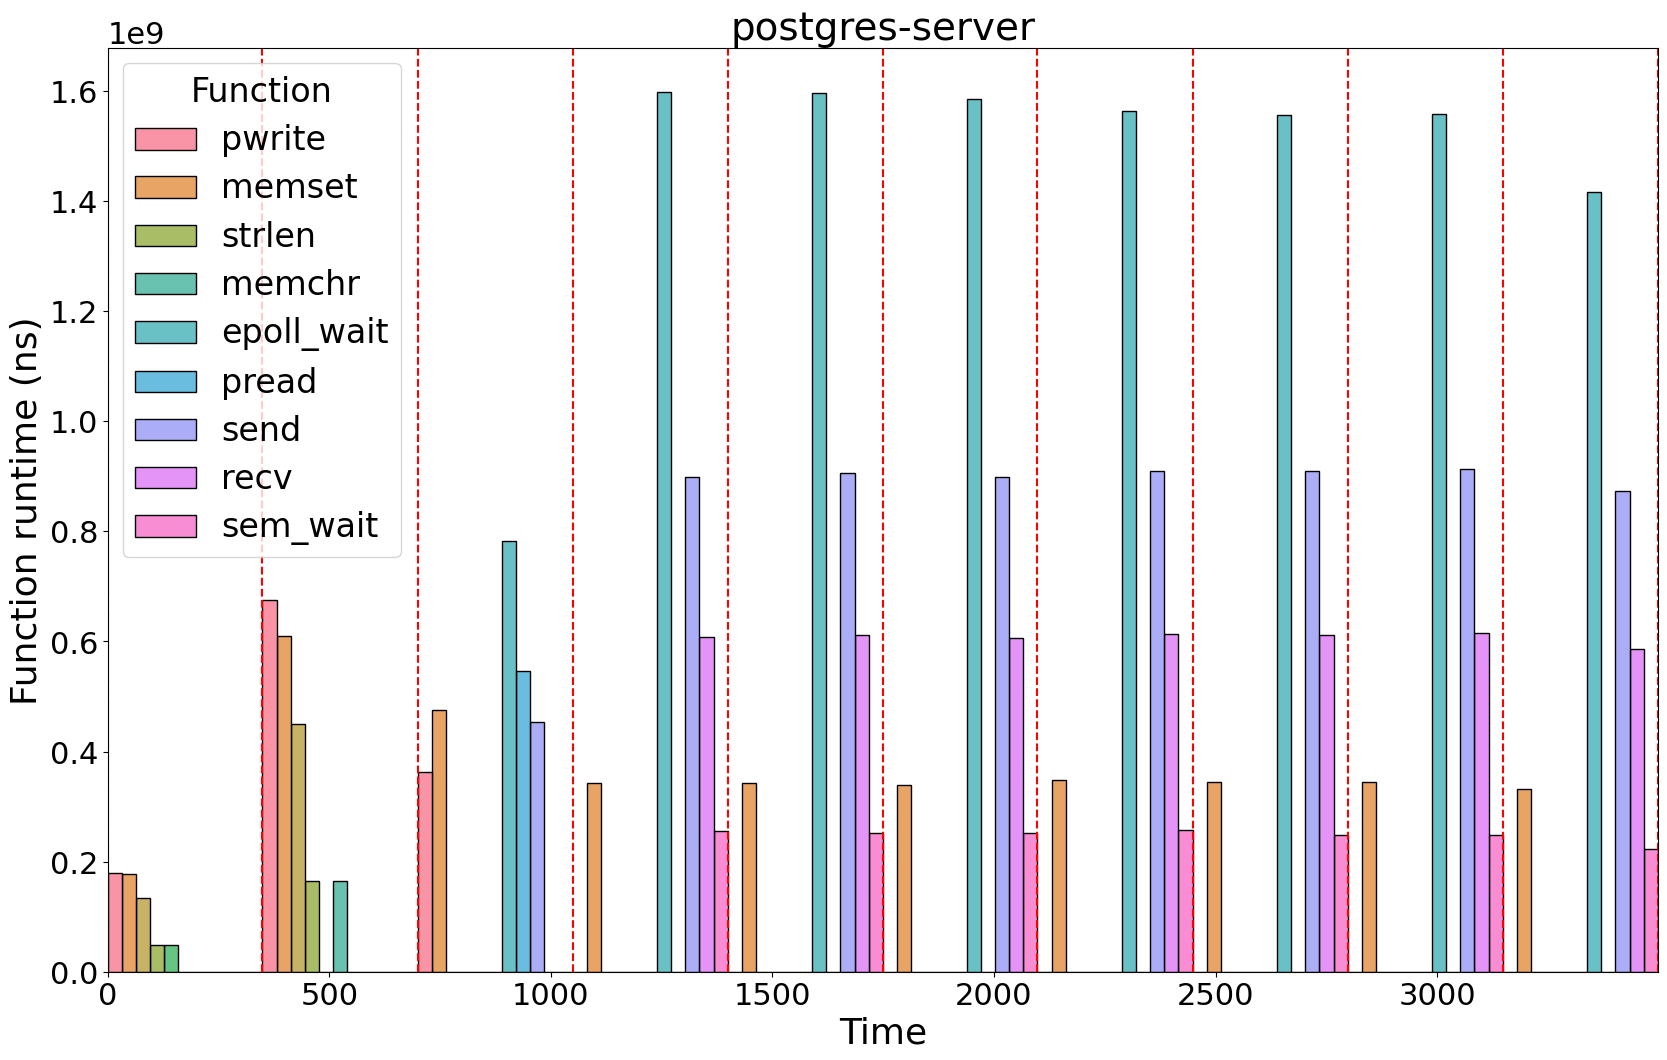

In [52]:
fig, ax = plt.subplots(figsize=[20,12])
ax.set_xlim(0, max_index)

sns.histplot(data=runtimes, x="Time", hue="Function", weights="Duration", multiple="dodge", bins=indices)

for index in indices:
    ax.axvline(x=index, color="red", linestyle="--")

# Set axes numbers size
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
ax.yaxis.get_offset_text().set_fontsize(22)

# Change legend font size
plt.setp(ax.get_legend().get_texts(), fontsize='24')
plt.setp(ax.get_legend().get_title(), fontsize='24')

ax.set_xlabel("Time", size=26)
ax.set_ylabel("Function runtime (ns)", size=26)
plt.title(workload, size=28)

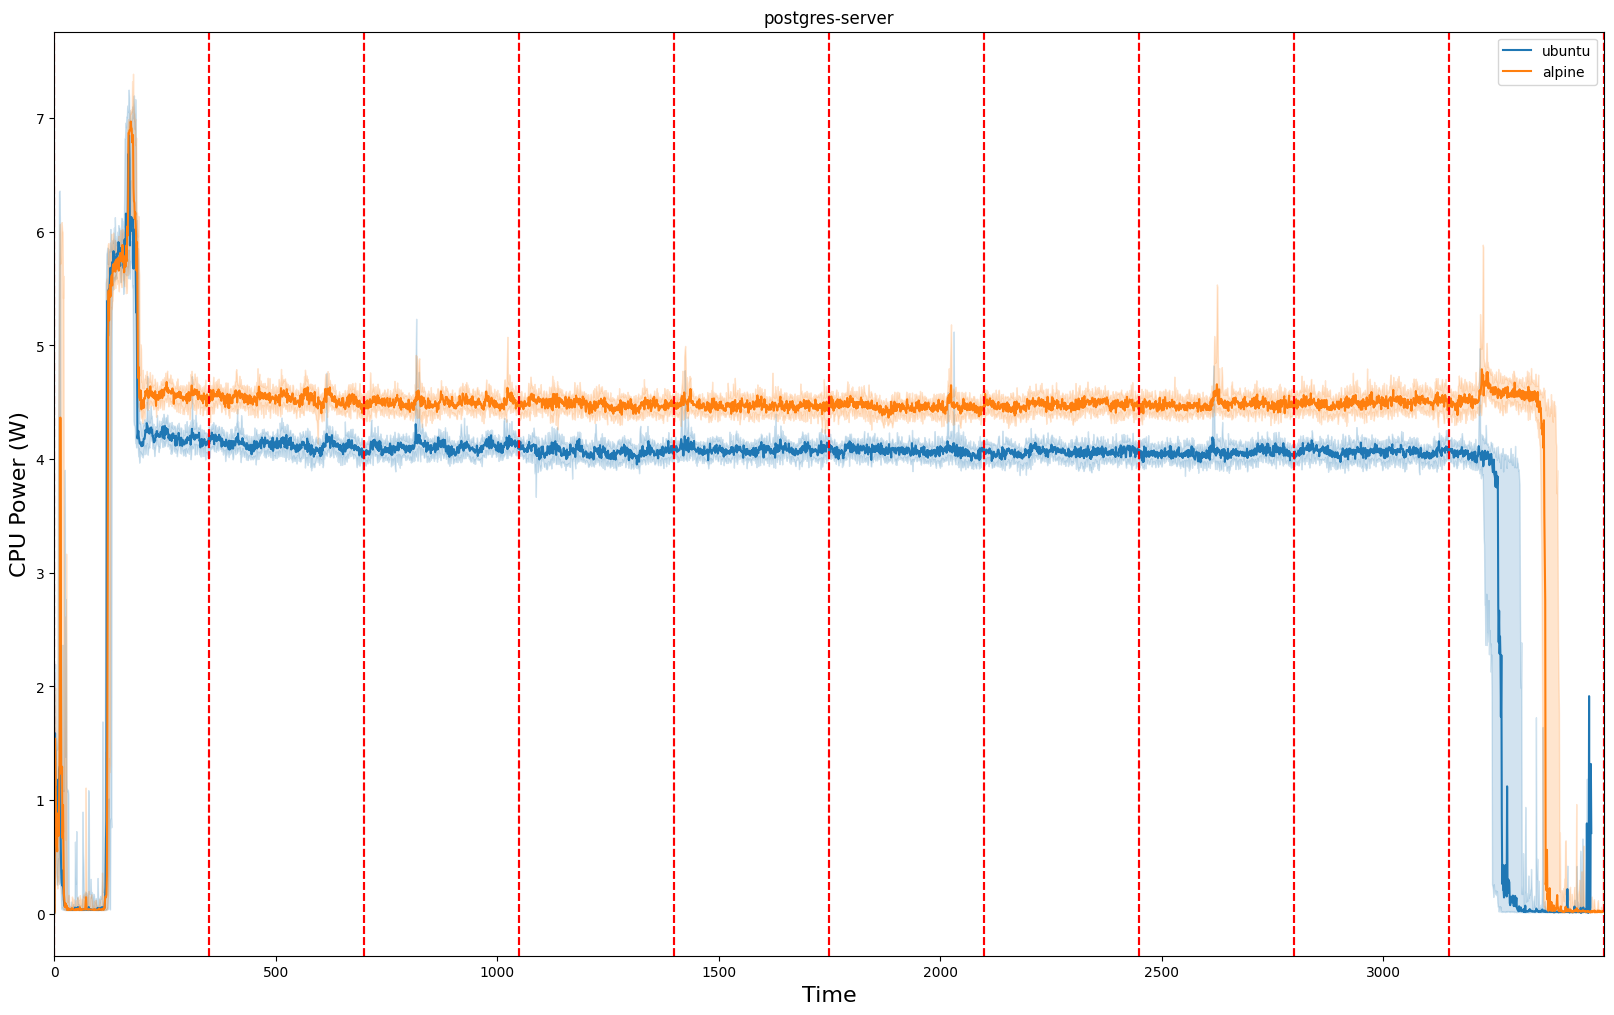

In [127]:
_,_ =energy_data(workload, images, indices=indices, xlim=(0, max_index))